In [3]:
!pip install FlowCal

     |████████████████████████████████| 82 kB 195 kB/s eta 0:00:01
     |████████████████████████████████| 243 kB 2.7 MB/s eta 0:00:01
  Created wheel for FlowCal: filename=FlowCal-1.3.0-py3-none-any.whl size=84554 sha256=97665e06a15dd4f17fc205c57d82cfe464be6a481e27aeaa6357b86f6867cf5e
  Stored in directory: /root/.cache/pip/wheels/59/b3/d2/c263ebe3ccd5e34236aeb7b9aa4285ecdb9e91587c9c959e2a
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=1b2c5772f5729f02b6d444fa93dd33c59ec3ef53d9761a4266e07d411322d7aa
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built FlowCal et-xmlfile


In [1]:
!pip install dca

     |████████████████████████████████| 10.3 MB 6.7 MB/s eta 0:00:01
     |████████████████████████████████| 127 kB 10.4 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 877 kB/s  eta 0:00:01
     |████████████████████████████████| 63 kB 1.1 MB/s  eta 0:00:01
  Created wheel for kopt: filename=kopt-0.1.0-py2.py3-none-any.whl size=20597 sha256=fc713ccae720c6e78e84beaa7eac52364d35059b35f0377b3376a732fd39d2d2
  Stored in directory: /root/.cache/pip/wheels/0b/ab/0f/bd1991eb21c86d65557c2f98182e91d4256ffd79942225ed57
  Created wheel for sinfo: filename=sinfo-0.3.1-py3-none-any.whl size=7016 sha256=cefdf5bc442ff686c701bb897f178ac491568601b763a1ab68af49592f324520
  Stored in directory: /root/.cache/pip/wheels/e3/34/c1/631dc06e37edbffced1c8a99dedf3acf05666078106524cc96
Successfully built kopt sinfo


In [58]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib 
from matplotlib import pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import FlowCal
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense

In [46]:
# Sort the file names
FCS_data = []
labels = []
data_dir = "/kaggle/input/samusik-scrna-data/"
for i in os.listdir(data_dir):
    if "csv" in i:
        labels.append(data_dir + i)
    elif "fcs" in i:
        FCS_data.append(data_dir + i)

FCS_data.sort()
labels.sort()
#print(FCS_data)
#print(labels)

In [54]:
# Keras DataGenerator
# We use this to load the data as we need it every epoch

class DataGenerator(Sequence):
    
    """
    fcs_files = List of .fcs files in directory
    labels = list of .csv files in directory (sorted the same as fcs_files)
    batch_size = number of scRNA data points to consider in a batch
       DataGenerator will sample [batch_size/len(list_IDs)] samples from each fcs file
       Each file has ~87K samples
    n_classes = 25 (24 cells, 1 no cell type listed (0))    
    
    """
    def __init__(self, fcs_files, labels, batch_size=30000, n_classes=25, shuffle=True):
        self.n_features = 51 # Each sample has 51 features
        self.batch_size = batch_size
        self.labels = labels
        self.fcs_files = fcs_files
        self.n_classes = n_classes
        self.shuffle = shuffle
        
        # Make an index over all samples
        # self.length is an int for the total number of samples
        # self.indices is a list of ints that tell us which index belongs to what file
        self.length, self.indices = self.compute_length(labels)
        self.indexes = np.array([i for i in range(self.length)])
        self.on_epoch_end()
        
    def compute_length(self, labels):
        L = 0
        FL = []
        for l in labels:
            df = pd.read_csv(l)
            L = L + len(df)
            FL.append(L)
        return L, FL
            
    def __len__(self):
        return self.length // self.batch_size
    
    def __getitem__(self, index):
        
        X = np.zeros((self.batch_size, self.n_features))
        #y = np.zeros(self.batch_size)
        
        # start and end index X and y
        start = 0
        end = 0
        
        # Prev max indexes globally for all samples
        prev_max = 0
        
        # idx/index both hold the global sample indexes we want
        idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        # bin them according to files in which they reside
        for i, max_file_index in enumerate(self.indices):
            
            file_idx = idx[idx < max_file_index] - prev_max
            
            if len(file_idx) == 0:
                continue
                
            end = start + len(file_idx)
            #print(len(file_idx))
            
            # Read each fcs file to get the samples
            si = FlowCal.io.FCSData(self.fcs_files[i])
            si = np.arcsinh(si[file_idx])   
            X[start:end] = si 
        
            # Unnecessary for autoencoder
            # Read each csv to get the labels
            #file_labels = pd.read_csv(self.labels[i])["Population"].to_numpy()
            #y[start:end] = file_labels[file_idx]
        
            # Update the indexing
            start = end
            idx = idx[idx >= max_file_index]
            prev_max = max_file_index
            
        return X, X
    
    def on_epoch_end(self):
        
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
        
    

In [55]:
# Split files for training, validation, testing
#DG = DataGenerator(FCS_data, labels)
TrainDG = DataGenerator(FCS_data[:6], labels[:6])
ValidateDG = DataGenerator([FCS_data[7]], [labels[7]])
TestDG = DataGenerator([FCS_data[8]], [labels[8]])

In [56]:
"""
Build the simplest possible decoder & encoder
Feed Forward NN with 2 layers

"""

AE2layer = Sequential()
AE2layer.add(Dense(2, input_dim=51, activation="relu", name="encoder"))
AE2layer.add(Dense(51, activation="relu", name="decoder"))
AE2layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

history_2layer = AE2layer.fit(x=TrainDG, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=50,
                              validation_data=ValidateDG)

Epoch 1/50
17/17 [==============================] - 3s 157ms/step - loss: 12.4736 - mse: 12.4736 - val_loss: 12.0026 - val_mse: 12.0026
Epoch 2/50
17/17 [==============================] - 3s 148ms/step - loss: 12.1387 - mse: 12.1387 - val_loss: 11.6420 - val_mse: 11.6420
Epoch 3/50
17/17 [==============================] - 3s 152ms/step - loss: 11.7668 - mse: 11.7668 - val_loss: 11.2630 - val_mse: 11.2630
Epoch 4/50
17/17 [==============================] - 2s 147ms/step - loss: 11.3466 - mse: 11.3466 - val_loss: 10.9041 - val_mse: 10.9041
Epoch 5/50
17/17 [==============================] - 2s 145ms/step - loss: 10.9124 - mse: 10.9124 - val_loss: 10.6057 - val_mse: 10.6057
Epoch 6/50
17/17 [==============================] - 2s 145ms/step - loss: 10.5196 - mse: 10.5196 - val_loss: 10.3558 - val_mse: 10.3558
Epoch 7/50
17/17 [==============================] - 2s 148ms/step - loss: 10.1742 - mse: 10.1742 - val_loss: 10.1062 - val_mse: 10.1062
Epoch 8/50
17/17 [==============================

2/2 [==============================] - 0s 75ms/step - loss: 8.6868 - mse: 8.6868


[8.68680477142334, 8.68680477142334]

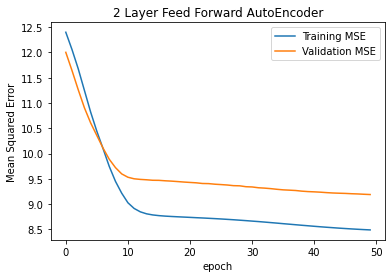

In [70]:
"""
Simplest FF Autoencoder metrics
It seems to overfit, makes sense that it does.
"""

plt.figure(1)
plt.plot(history_2layer.history["loss"])
plt.plot(history_2layer.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("2 Layer Feed Forward AutoEncoder")
plt.savefig("2layerMetrics")

AE2layer.evaluate(x=TestDG, use_multiprocessing=True, workers=-1)

[20.  7.  0. ... 14.  8.  7.]


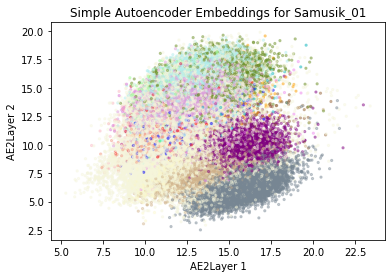

In [75]:
"""
Embeddings generated by simplest FF Model
"""
s01 = FlowCal.io.FCSData(FCS_data[0])
s01 = np.arcsinh(np.array(s01))

simple_encoder = AE2layer.get_layer("encoder")
s01_encoding = simple_encoder(s01)

labels = np.array(pd.read_csv(data_dir + "population_assignments01.csv")["Population"])
print(labels)

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure(2)
plt.scatter(s01_encoding[:, 0], s01_encoding[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("AE2Layer 1")
plt.ylabel("AE2Layer 2")
plt.title("Simple Autoencoder Embeddings for Samusik_01")
plt.savefig("2 layer AE embeddings samusik_01")


In [64]:
"""
Add a few layers to the network, see how it changes embeddings
Still a simple FF model

"""
AE6layer = Sequential()
AE6layer.add(Dense(20, input_dim=51, activation="relu", name="encoder1"))
AE6layer.add(Dense(10, activation="relu", name="encoder2"))
AE6layer.add(Dense(2, activation="relu", name="encoder3"))
AE6layer.add(Dense(10, activation="relu", name="decoder1"))
AE6layer.add(Dense(20, activation="relu", name="decoder2"))
AE6layer.add(Dense(51, activation="relu", name="decoder3"))
AE6layer.compile(loss="mse", optimizer="adam", metrics=["mse"])

history_6layer = AE6layer.fit(x=TrainDG, 
                              use_multiprocessing=True,
                              workers=-1,
                              epochs=50,
                              validation_data=ValidateDG)

Epoch 1/50
17/17 [==============================] - 3s 169ms/step - loss: 12.5291 - mse: 12.5291 - val_loss: 11.2966 - val_mse: 11.2966
Epoch 2/50
17/17 [==============================] - 3s 157ms/step - loss: 10.9071 - mse: 10.9071 - val_loss: 8.8073 - val_mse: 8.8073
Epoch 3/50
17/17 [==============================] - 3s 157ms/step - loss: 8.4676 - mse: 8.4676 - val_loss: 7.2214 - val_mse: 7.2214
Epoch 4/50
17/17 [==============================] - 3s 157ms/step - loss: 6.6436 - mse: 6.6436 - val_loss: 5.7774 - val_mse: 5.7774
Epoch 5/50
17/17 [==============================] - 3s 157ms/step - loss: 5.3016 - mse: 5.3016 - val_loss: 4.7666 - val_mse: 4.7666
Epoch 6/50
17/17 [==============================] - 3s 161ms/step - loss: 4.4418 - mse: 4.4418 - val_loss: 4.4081 - val_mse: 4.4081
Epoch 7/50
17/17 [==============================] - 3s 158ms/step - loss: 4.1804 - mse: 4.1804 - val_loss: 4.3394 - val_mse: 4.3394
Epoch 8/50
17/17 [==============================] - 3s 160ms/step - lo

2/2 [==============================] - 0s 75ms/step - loss: 3.5103 - mse: 3.5103


[3.510270118713379, 3.510270118713379]

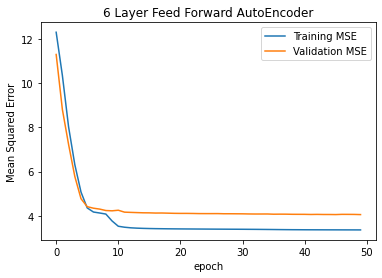

In [72]:
"""
6 layer FF Autoencoder metrics
It also seems to overfit, but it did much better than the 2 layer model.
"""

plt.figure(1)
plt.plot(history_6layer.history["loss"])
plt.plot(history_6layer.history["val_loss"])
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")
plt.legend(["Training MSE", "Validation MSE"])
plt.title("6 Layer Feed Forward AutoEncoder")
plt.savefig("6layerMetrics")

AE6layer.evaluate(x=TestDG, use_multiprocessing=True, workers=-1)

[20.  7.  0. ... 14.  8.  7.]


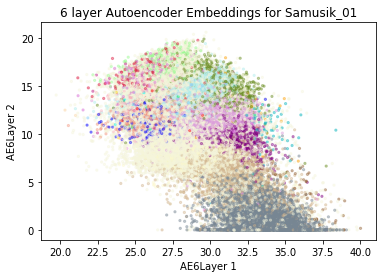

In [74]:
"""
Embeddings generated by simplest FF Model
"""
s01 = FlowCal.io.FCSData(FCS_data[0])
s01 = np.arcsinh(np.array(s01))

e1 = AE6layer.get_layer("encoder1")
e2 = AE6layer.get_layer("encoder2")
e3 = AE6layer.get_layer("encoder3")
s01_encoding = e3(e2(e1(s01)))

labels = np.array(pd.read_csv(data_dir + "population_assignments01.csv")["Population"])
print(labels)

color_list = ["beige","violet","red","blue","lightsalmon", "cyan","orchid", "plum", 'olivedrab', 'palegreen', 'gold', 'tan', 'slategray','lemonchiffon', "paleturquoise","pink","crimson","orange","mediumvioletred","lightskyblue","navajowhite","sienna","springgreen","c","purple"]
cmap_own = matplotlib.colors.LinearSegmentedColormap.from_list("", color_list)

plt.figure()
plt.scatter(s01_encoding[:, 0], s01_encoding[:, 1], c = labels,s=5, alpha=0.4, cmap = cmap_own)
plt.xlabel("AE6Layer 1")
plt.ylabel("AE6Layer 2")
plt.title("6 layer Autoencoder Embeddings for Samusik_01")
plt.savefig("6 layer AE embeddings samusik_01")

In [ ]:
"""
Build a variational auto encoder

"""